# Clustering of ENRON emails  with BERT embedding 

## Introduction

### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

Let's get started!

## Install and Import

In [0]:
# to get more RAM
a = []
while(1):
    a.append('1')

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for BERT by Hugging Face Transformer. 

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [3]:
!pip install transformers

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'


## Load ENRON emails


In [0]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

In [10]:
n_emails=800
df = pd.read_csv("cleaned_small_email.csv", delimiter='\t', header=None, names=[ 'emails'])

df=df[0:n_emails]
df.shape

(800, 1)

In [11]:
df.sample(10)

,emails
342,"allen-p/_sent_mail/41.,ina please forward pr..."
189,"allen-p/_sent_mail/264.,one home meet dsl ins..."
621,"allen-p/all_documents/115.,nymex expiration ti..."
708,"allen-p/all_documents/196.,lucy didnt get fa..."
113,"allen-p/_sent_mail/196.,ina keep getting secu..."
347,"allen-p/_sent_mail/414.,jacques office rest w..."
598,"allen-p/_sent_mail/95.,xorigin allenp xfilenam..."
193,"allen-p/_sent_mail/268.,today chart attached,2..."
772,"allen-p/all_documents/254.,mary add balance t..."
146,"allen-p/_sent_mail/225.,attached please find s..."


In [0]:
# Create sentence and label lists
emails = df.emails.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
emails = ["[CLS] " + email + " [SEP]" for email in emails]


## Prepare BERT 

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_texts = [tokenizer.tokenize(sent) for sent in emails]
print ("Tokenize the first sentence:")
print (tokenized_texts[4])

Tokenize the first sentence:
['[CLS]', 'allen', '-', 'p', '/', '_', 'sent', '_', 'mail', '/', '1000', '.', ',', 'randy', 'send', 'schedule', 'salary', 'level', 'everyone', 'scheduling', 'group', 'plus', 'thought', 'change', 'need', 'made', 'patti', 'example', 'phillip', ',', '2000', '-', '10', '-', '23', '06', ':', '13', ':', '00', '-', '07', ':', '00', ',', 'phillip', '.', 'allen', '@', 'en', '##ron', '.', 'com', ',', 'randall', '.', 'gay', '@', 'en', '##ron', '.', 'com', ',', '[SEP]']


In [14]:
print (tokenized_texts[4])

['[CLS]', 'allen', '-', 'p', '/', '_', 'sent', '_', 'mail', '/', '1000', '.', ',', 'randy', 'send', 'schedule', 'salary', 'level', 'everyone', 'scheduling', 'group', 'plus', 'thought', 'change', 'need', 'made', 'patti', 'example', 'phillip', ',', '2000', '-', '10', '-', '23', '06', ':', '13', ':', '00', '-', '07', ':', '00', ',', 'phillip', '.', 'allen', '@', 'en', '##ron', '.', 'com', ',', 'randall', '.', 'gay', '@', 'en', '##ron', '.', 'com', ',', '[SEP]']


(array([ 10., 408., 180.,  65.,  48.,  20.,  19.,   8.,   4.,   2.,   3.,
          3.,   0.,   7.,   0.,   0.,   1.,   5.,   0.,   3.,   0.,   0.,
          2.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  13.  ,   46.32,   79.64,  112.96,  146.28,  179.6 ,  212.92,
         246.24,  279.56,  312.88,  346.2 ,  379.52,  412.84,  446.16,
         479.48,  512.8 ,  546.12,  579.44,  612.76,  646.08,  679.4 ,
         712.72,  746.04,  779.36,  812.68,  846.  ,  879.32,  912.64,
         945.96,  979.28, 1012.6 , 1045.92, 1079.24, 1112.56, 1145.88,
        1179.2 , 1212.52, 1245.84, 1279.16, 1312.48, 1345.8 , 1379.12,
        1412.44, 1445.76, 1479.08, 1512.4 , 1545.72, 1579.04, 1612.36,
        1645.68, 1679.  ]),
 <a list of 50 Patch objects>)

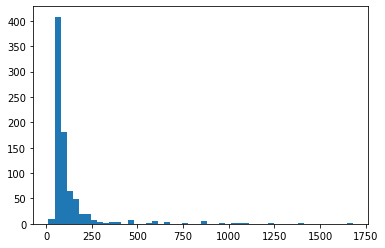

In [15]:
#check the length of emails
word_count=[len(tokenized_texts[i]) for i in range(len(tokenized_texts))]
plt.hist(word_count,bins=50)
# it's safe for now to chose a length of 256 words

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. We use one sentence inputs, this is simply a sequence of 0s. 
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens .
- **labels**: Not suitable for us.

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

In [17]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (592 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (592 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (858 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (858 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (759 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [19]:
#the first 128 words' index in BERT vocabulary
input_ids[40]

array([  101,  5297,  1011,  1052,  1013,  1035,  2741,  1035,  5653,
        1013,  2410,  1012,  1010,  3958,  2183,  3034,  2655,  2828,
        4882,  3116, 10738,  3277,  5307,  2662,  2733,  2191,  2469,
        3806,  4624,  2443, 10852,  1010,  2541,  1011,  5709,  1011,
        6185,  2260,  1024,  4029,  1024,  4002,  1011,  5718,  1024,
        4002,  1010, 10852,  1012,  5297,  1030,  4372,  4948,  1012,
        4012,  1010,  2508,  1012, 26261, 16020,  2015,  1030,  4372,
        4948,  1012,  4012,  1010,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
train_inputs=input_ids
train_masks= attention_masks

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

input_ids_tensor = torch.tensor(train_inputs)
masks_tensor = torch.tensor(train_masks)

In [23]:
train_inputs.shape

(800, 256)

## Get encoded layers via BERT

In [0]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [6]:
# Load pre-trained model (weights)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model( input_ids_tensor ,masks_tensor.to(torch.int64))

In [28]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of emails:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens in each email:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of emails: 800
Number of tokens in each email: 256
Number of hidden units: 768


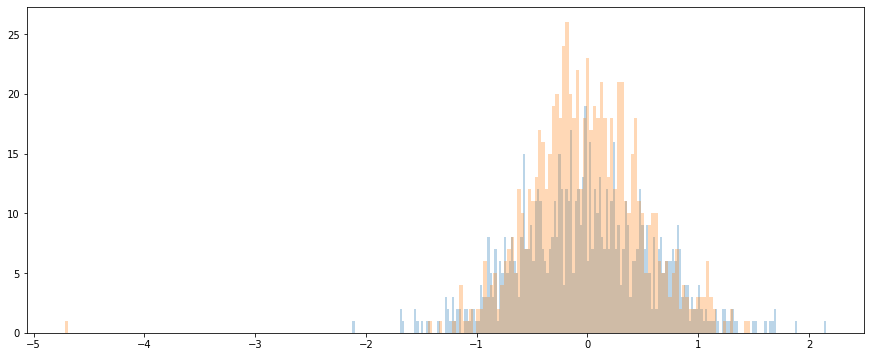

In [33]:
# For the 3 random tokens in our mail, select its feature values from layer 12.
token_i = 4
layer_i = 11
vec = encoded_layers[layer_i][batch_i][token_i]
vec2=encoded_layers[layer_i][batch_i][token_i+1]
vec3=encoded_layers[layer_i][batch_i][token_i+5]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15,6))
#plt.hist(vec, bins=200,alpha=0.3)
plt.hist(vec2, bins=200,alpha=0.3)
plt.hist(vec3, bins=200,alpha=0.3)
plt.show()

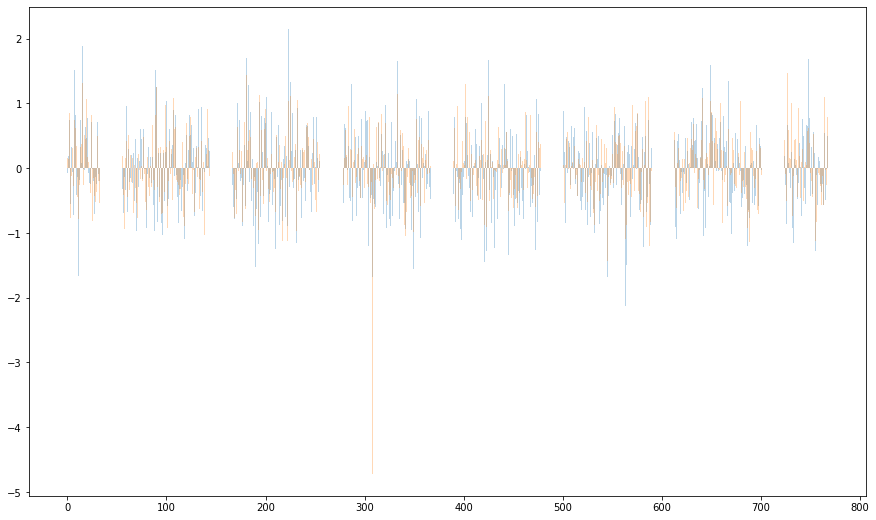

In [37]:
# For the 3 random tokens in our mail, select its feature values from layer 12.
token_i = 4
layer_i = 11
vec = encoded_layers[layer_i][batch_i][token_i]
vec2=encoded_layers[layer_i][batch_i][token_i+1]
vec3=encoded_layers[layer_i][batch_i][token_i+5]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15,9))
#plt.bar(range(768),vec,alpha=0.3)
plt.bar(range(768),vec2, alpha=0.3)
plt.bar(range(768),vec3, alpha=0.3)
plt.show()

In [38]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([800, 256, 768])


##### Save the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
torch.save(encoded_layers,'/content/drive/My Drive/BERTencoded_layers.pt')

## Get embedding with 4 last layers

In [39]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

torch.Size([12, 800, 256, 768])

In [40]:
#Finally, we can switch around the “layers” and “tokens” dimensions with permute.

# Swap dimensions 0 and 1.
text_embeddings = token_embeddings.permute(1,2,0,3)

text_embeddings.size()

torch.Size([800, 256, 12, 768])

In [41]:
text_embeddings[0].size()

torch.Size([256, 12, 768])

## Text Vectors
To get a single vector for our entire email we have multiple application-dependent strategies, 
but a simple approach is to average all tokens of an email producing a single 768 length vector.

In [43]:
# `text_embeddings` is a [n_emails, 128, 12, 768] tensor.

text_vecs = []

for text in text_embeddings:
  # Stores the token vectors
  token_vecs_sum = []

  # For each token in the text[128, 12, 768]
  for token in text:
    
      # `token` is a [12 x 768] tensor

      # Sum the vectors from the last four layers.
      sum_vec = torch.sum(token[-4:], dim=0)
    
      # Use `sum_vec` to represent `token`.
      token_vecs_sum.append(sum_vec)
  
  text_vecs.append(token_vecs_sum)
  
print ('Shape of word vector is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))
print ('Shape of text vector: %d x %d x ' % (len(text_vecs), len(text_vecs[0])),text_vecs[0][0].size())

Shape of word vector is: 256 x 768
Shape of text vector: 800 x 256 x  torch.Size([768])


In [0]:
email_embedding=[]
for email in text_vecs:
  #print(email)
  word_embedding_sum=np.zeros(768)
  for word in email:
    word_embedding_sum=word_embedding_sum+word.cpu().numpy()
  email_embedding.append(np.array(word_embedding_sum)/128)


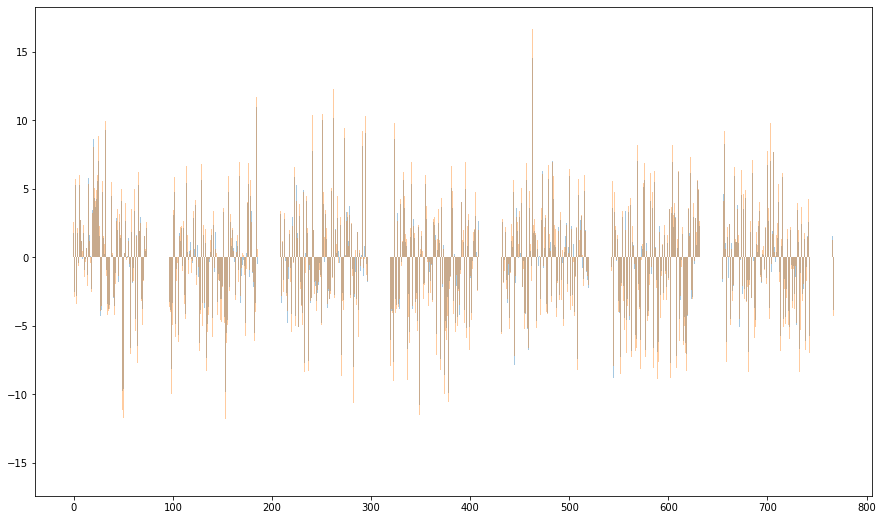

In [48]:
vec =email_embedding[100]
vec2=email_embedding[4]
vec3=email_embedding[6]
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15,9))
plt.bar(range(768),vec,alpha=0.4)
plt.bar(range(768),vec2, alpha=0.4)
#plt.bar(range(768),vec3, alpha=0.3)
plt.show()

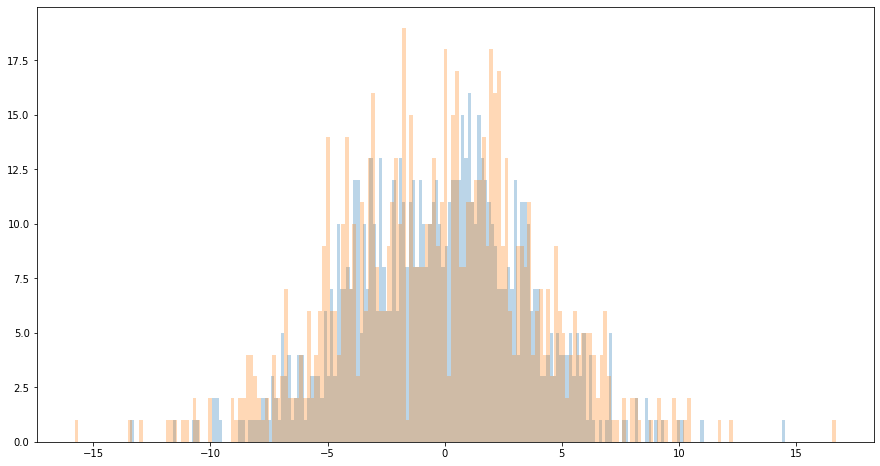

In [50]:
# For the 3 random  mail, visualise the representation features.

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(15,8))
plt.hist(vec, bins=200,alpha=0.3)
plt.hist(vec2, bins=200,alpha=0.3)
#plt.hist(vec3, bins=200,alpha=0.3)
plt.show()

In [0]:
# save the embedding
torch.save(email_embedding,'/content/drive/My Drive/email_embedding.pt')

In [0]:
import csv
with open('/content/drive/My Drive/email_embedding.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(email_embedding)

## K Means

In [0]:
# transform list to array
email_embedding_array = np.array(email_embedding)

In [0]:
from sklearn.cluster import KMeans
N = 5
clf = KMeans(n_clusters=N,
             max_iter=50,
             init='k-means++',
             n_init=4)
labels = clf.fit_predict(email_embedding_array)

Visualisation with PCA


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(email_embedding_array)
datapoint = pca.transform(email_embedding_array)

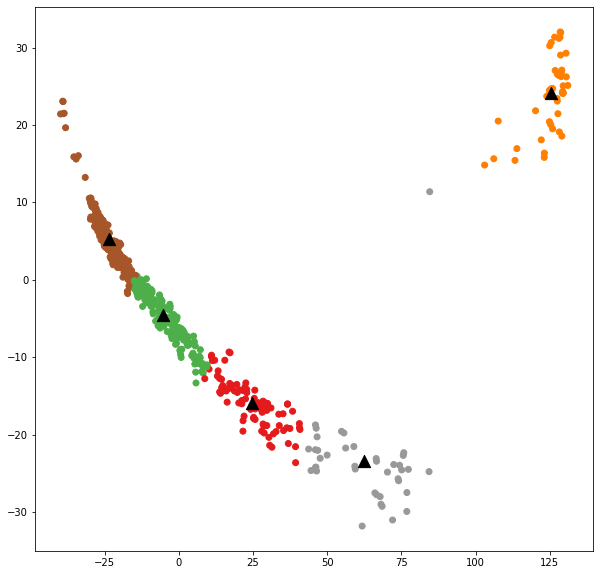

In [54]:
plt.figure(figsize=(10,10))
plt.scatter(datapoint[:, 0], datapoint[:, 1],c  = labels,cmap='Set1')

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [0]:
pca = PCA(n_components=3).fit(email_embedding_array)
datapoint = pca.transform(email_embedding_array)

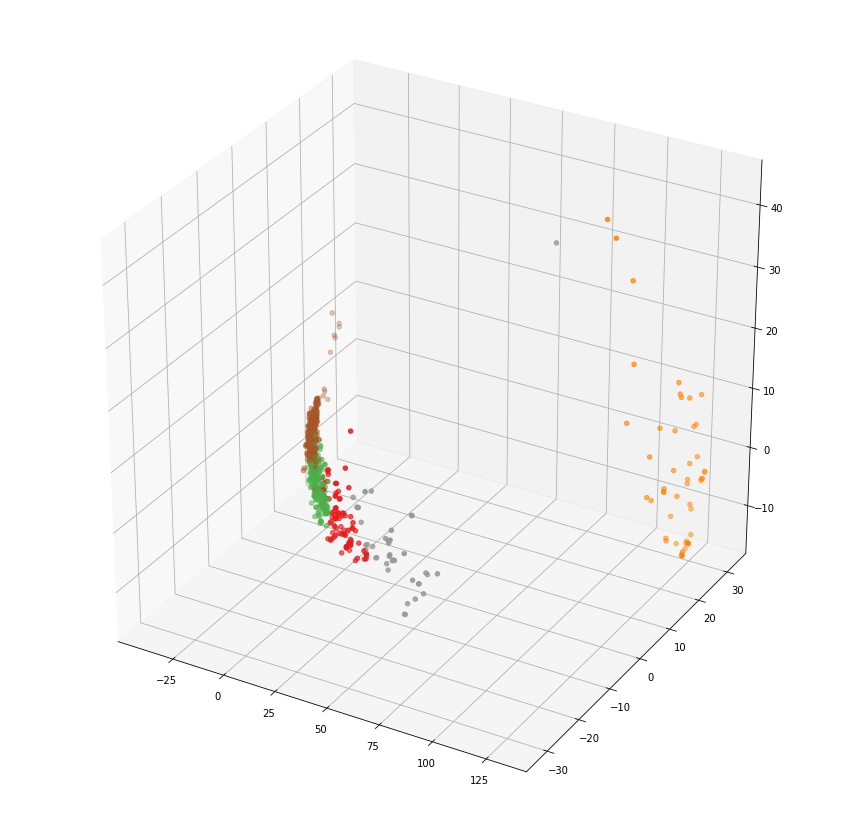

In [56]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(datapoint[:, 0], datapoint[:, 1], datapoint[:, 2],c  = labels,cmap='Set1')
plt.show()

Visualisation with TSNE

In [0]:
from sklearn.manifold import TSNE
tSNE = TSNE(n_components=2)
datapoint = tSNE.fit_transform(email_embedding_array)

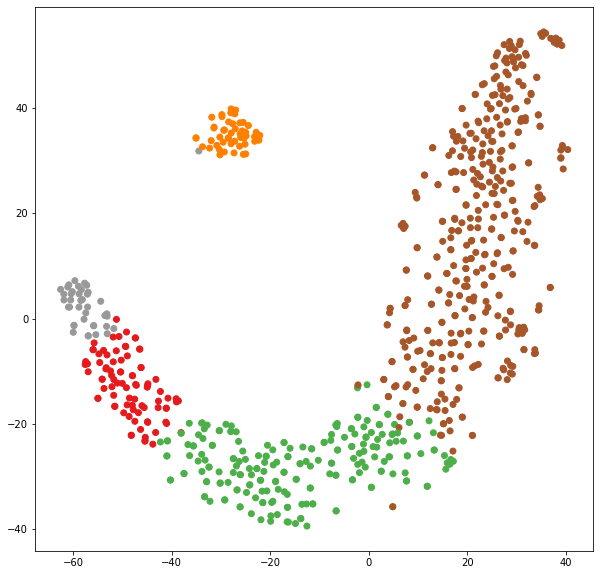

In [58]:
plt.figure(figsize=(10,10))
plt.scatter(datapoint[:, 0], datapoint[:, 1],c  = labels,cmap='Set1')
plt.show()

In [0]:
tSNE = TSNE(n_components=3)
datapoint = tSNE.fit_transform(email_embedding_array)

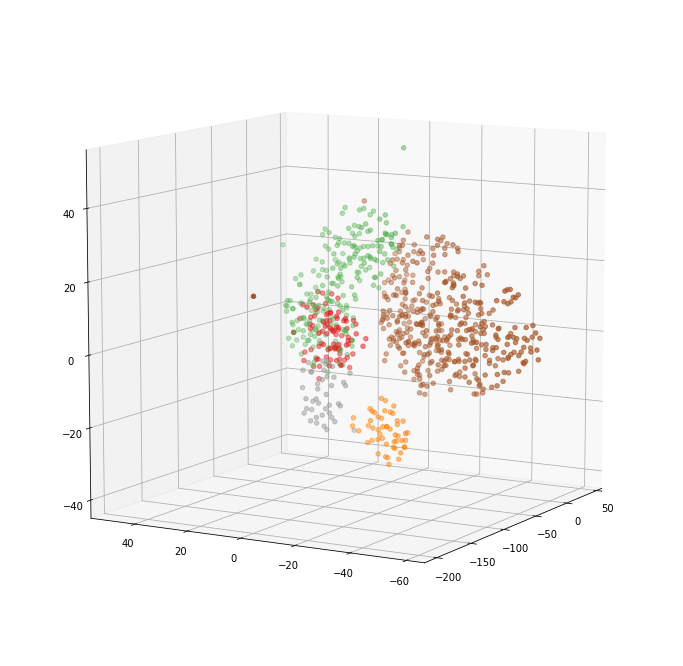

In [74]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(datapoint[:, 0], datapoint[:, 1], datapoint[:, 2],c  = labels,cmap='Set1')

ax.view_init(elev=10., azim=210)


plt.show()

## Evaluation of clustering

### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.

- b: The mean distance between a sample and all other points in the next nearest cluster.

- s=(b-a)/max(a,b)

The Silhouette Coefficient s for a single sample is then given as:

 
The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.


Advantages
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [75]:
from sklearn import metrics
#from sklearn.metrics import pairwise_distances
metrics.silhouette_score(email_embedding_array, labels, metric='euclidean')

0.4306551834696948

### Davies-Bouldin Index
If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.texte en gras

In [76]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(email_embedding_array, labels)

0.878737205096505

# Keyword Extraction

https://monkeylearn.com/keyword-extraction/

What is Keyword Extraction?
Keyword extraction (also known as keyword detection or keyword analysis) is a text analysis technique that consists of automatically extracting the most important words and expressions in a text. It helps summarize the content of a text and recognize the main topics which are being discussed.